In [1]:
import sys
import os

import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import numpy as np
import itertools as it

sys.path.append('../3_score/')
from optimize import Scores
from load_data import *
from plotting_tools import *
from receptor import *

In [ ]:
data = '/scratch/PI/rondror/docking_data'
u_lig = lambda x:len(os.listdir('{}/{}/final_ligands'.format(data, x)))
all_datasets = ['pdbbind_combo/{}'.format(s) for s in os.listdir('{}/pdbbind_combo'.format(data))]
all_datasets.sort(key=lambda x: -u_lig(x))
all_datasets = list(filter(lambda x: u_lig(x) >= 15, all_datasets))

grids = load_grids()

In [ ]:
all_datasets = ['B1AR_all']
grids = {'B1AR_all':os.listdir('/scratch/PI/rondror/docking_data/{}/final_ligands'.format(all_datasets[0]))}
grids = {r:[i.split('_')[0] for i in grids[r]] for r in grids}

In [ ]:
receptor = 'B2AR_all'
structs = ['2RH1']
r = Receptor(receptor, structs)

In [ ]:
c = r.structs[structs[0]].biggest_cluster()

In [ ]:
get_ipython().magic(u'matplotlib inline')

c.plot_final_rmsds()

In [ ]:
c.export('test2', 'B2AR_all', '2RH1')

In [2]:
r2 = 'pdbbind_combo/P03367'
grids = load_grids()
print grids[r2]

['1HVL', '1DIF']


In [3]:
r22 = Receptor(r2, grids[r2])


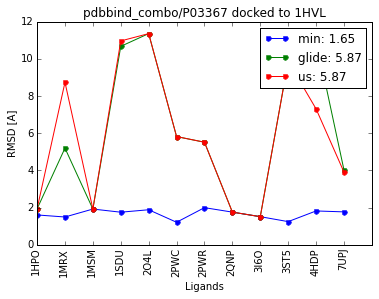

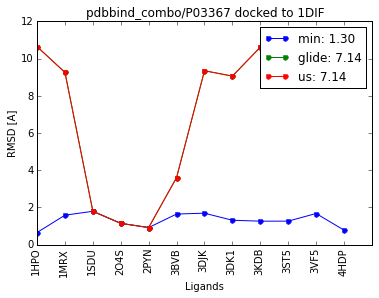

In [4]:
get_ipython().magic(u'matplotlib inline')
for sname, s in r22.structs.items():
    c2 = s.biggest_cluster()
    c2.plot_final_rmsds(title='{} docked to {}'.format(r2, sname))
    #c2.export(sname, r2, sname)

In [5]:
a, b, c = c2.score_breakdown()

In [6]:
print a, b
print c.keys()

24.32925 6.35302886901
['A:8(ARG)', 'A:23(LEU)', 'A:48(GLY)', 'B:25(ASP)', 'B:28(ALA)', 'A:81(PRO)', 'A:29(ASP)', 'B:82(VAL)', 'B:84(ILE)', 'B:27(GLY)', 'B:49(GLY)', 'B:76(LEU)', 'B:47(ILE)', 'A:47(ILE)', 'A:76(LEU)', 'A:49(GLY)', 'B:32(VAL)', 'A:30(ASP)', 'A:31(THR)', 'A:84(ILE)', 'B:48(GLY)', 'B:23(LEU)', 'A:82(VAL)', 'A:32(VAL)', 'A:50(ILE)', 'A:87(ARG)', 'B:50(ILE)', 'A:28(ALA)', 'B:8(ARG)', 'A:27(GLY)', 'A:25(ASP)', 'B:30(ASP)', 'B:81(PRO)', 'B:31(THR)', 'B:29(ASP)']


In [ ]:
all_loaded_data = {r:{} for r in all_datasets}
        
for receptor in all_datasets:
    for i, s in enumerate(grids[receptor][:1]):
        (xcrystals, xglides) = load_data(receptor, s,
                                         w=[0,0,1,1,1,0.5,1,1,1,0.02,0,0,0],
                                         glide_ifp='xglide8', crystal_ifp='xcrystal8')
        if i == 0:
            all_loaded_data[receptor]['xcrystals'] = xcrystals
        all_loaded_data[receptor][s] = xglides

In [ ]:
all_scores = {r: {s:load_combinations(r, s, 'scoring_output') for s in all_loaded_data[r]} 
              for r in all_loaded_data}

In [ ]:
all_scores = {r: {grids[r][0]: Scores(all_loaded_data[r][grids[r][0]], all_loaded_data[r]['xcrystals'], 
                            all_loaded_data[r][grids[r][0]].keys(), grids[r][0], 25, gscore_weight=2.7)}
             for r in all_loaded_data}

In [ ]:
get_ipython().magic(u'matplotlib inline')
us_rmsds = []
glide_rmsds = []
for r in all_scores:
    for s in all_scores[r]:
        title = '{} docked to: {}. g={}'.format(r, s, 27)
        final_rmsds = plot_final_rmsds(all_scores[r][s], title)
        us_rmsds.extend([all_scores[r][s].get_top_rmsd(l, 1, False) for l in all_scores[r][s].ligands])
        glide_rmsds.extend([all_scores[r][s].get_top_rmsd(l, 1, True) for l in all_scores[r][s].ligands])

In [ ]:
print all_scores['pdbbind_combo/P00918']['1BCD'].keys()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.rc('font', weight='normal')

plt.plot([0,12],[0,12],'k')
plt.plot(us_rmsds, glide_rmsds, '.', markersize=10)
plt.axis([-0.5, 13, -0.5, 13])

ax = plt.gca()
ttl = ax.title
ttl.set_position([.5, 1.02])

#fig = plt.figure(figsize=(4, 5), dpi=100)

ax.set_aspect('equal')#abs(x1-x0)/abs(y1-y0))
plt.xlabel('Error in Physics + Data Prediction [RMSD, $\AA$]', size=20)
plt.ylabel('Error in Physics Prediction [RMSD, $\AA$]', size=20)

plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Adrenaline Receptor ($\\beta_1$AR) Performance', size=24)
plt.show()

In [ ]:
get_ipython().magic(u'matplotlib inline')

def cluster_rmsd(ligs, poses, glides, f=np.mean):
    assert len(ligs) == len(poses)
    return f([glides[l].poses[poses[i]].rmsd for i, l in enumerate(ligs)])

all_perf = {'u-ave':[],'g-ave':[],'u-med':[],'g-med':[],'u-success':[],'g-success':[],'n':[]}

for receptor in sorted(all_scores.keys(), key=lambda x: -u_lig(x)):
    for s in grids[receptor][:1]:
        #(xcrystals, xglides) = load_data(receptor, s,
        #                                 w=[0,0,10,10,10,5,10,10,10,0.2,0,0,0],
        #                                 glide_ifp='xglide8',
        #                                 crystal_ifp='xcrystal8')
        xcrystals = all_loaded_data[receptor]['xcrystals']
        xglides = all_loaded_data[receptor][s]
        tr = {1:[xglides[l].poses[0].rmsd for l in xglides.keys() if l != s]}
        print receptor, s
        print all_scores[receptor][s].keys()
        if all_scores[receptor][s] == {}: continue
        k = max(all_scores[receptor][s].keys())
        assert len(all_scores[receptor][s][k]) == 1
        
        our_ligs, our_poses = all_scores[receptor][s][k].items()[0]
        glide_poses = tuple([0 for i in our_ligs])
        
        all_perf['u-ave'].append(cluster_rmsd(our_ligs, our_poses, xglides, f=np.mean))
        all_perf['g-ave'].append(cluster_rmsd(our_ligs, glide_poses, xglides, f=np.mean))
        
        all_perf['u-med'].append(cluster_rmsd(our_ligs, our_poses, xglides, f=np.median))
        all_perf['g-med'].append(cluster_rmsd(our_ligs, glide_poses, xglides, f=np.median))
        
        def success(rmsd_list):
            return sum([1 for i in rmsd_list if i <= 2])/float(len(rmsd_list))
        
        all_perf['u-success'].append(cluster_rmsd(our_ligs, our_poses, xglides, f=success))
        all_perf['g-success'].append(cluster_rmsd(our_ligs, glide_poses, xglides, f=success))
        
        all_perf['n'].append(k)
        
        #for k in sorted(all_scores[receptor][s].keys()):
        #    for ligs, poses in all_scores[receptor][s][k].items():
            #print len(combo), np.mean([scores.get_top(l, 1, False) for l in combo])
        #        if k not in tr:
        #            tr[k] = []
        #        tr[k].append(cluster_rmsd(ligs, poses, xglides))

        #plt.plot([c for c, r in tr.items()], [np.mean(r) for c, r in tr.items()], '*-k', markersize=5)
        #max_y = 0
        #for combo_size, rmsds in tr.items():
        #    max_y = max(max(rmsds), max_y)
        #    plt.plot([combo_size], [np.mean(rmsds)], '*k', markersize=10)
        #    plt.plot([combo_size]*len(rmsds), rmsds, '.', markersize=5)
            #break
        #plt.title('{}: {}'.format(receptor, s))
        #plt.xlabel('Number of ligands')
        #plt.ylabel('RMSD')
        #plt.axis([0,max(tr.keys())+1, 0, max_y+1])
        #plt.show()


In [ ]:
print all_scores[receptor][s][k].items()

In [ ]:
get_ipython().magic(u'matplotlib inline')

num = 20

#for i in range(len(all_perf['n'])):
#for i in range(2):
plt.plot([0,10],[0,10])
#plt.plot([r for j, r in enumerate(all_perf['u-ave']) if j%2 == i], 
#         [r for j, r in enumerate(all_perf['g-ave']) if j%2 == i], '.')
plt.plot(all_perf['u-ave'][:num], all_perf['g-ave'][:num], '.')
plt.xlabel('us average rmsd')
plt.ylabel('glide average rmsd')
#plt.title(i)
plt.show()

In [ ]:
get_ipython().magic(u'matplotlib inline')

fig = plt.figure(figsize=(8,8))
plt.rc('font', weight='normal')

#plt.plot([0,12],[0,12],'k')
#plt.plot(us_rmsds, glide_rmsds, '.', markersize=10)
plt.axis([-0.5, 11, -0.5, 11])

ax = plt.gca()
ttl = ax.title
ttl.set_position([.5, 1.03])

#fig = plt.figure(figsize=(4, 5), dpi=100)

ax.set_aspect('equal')#abs(x1-x0)/abs(y1-y0))
plt.xlabel('Median Error in Physics + Data Prediction [RMSD, $\AA$]', size=20)
plt.ylabel('Median Error in Physics Prediction [RMSD, $\AA$]', size=20)

plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Performance on 20 Proteins in Standard Benchmark', size=24)
#plt.show()

#for i in range(len(all_perf['n'])):
#for i in range(2):
plt.plot([0,10],[0,10],'k')
#    plt.plot([r for j, r in enumerate(all_perf['u-med']) if j%2 == i], 
#             [r for j, r in enumerate(all_perf['g-med']) if j%2 == i], '.')
#for j in range(num):
plt.plot(all_perf['u-med'][:num], all_perf['g-med'][:num], '.', markersize=10)#all_perf['n'][j])
#plt.xlabel('us median rmsd')
#plt.ylabel('glide median rmsd')
#    plt.title(i)
plt.show()

In [ ]:
get_ipython().magic(u'matplotlib inline')
#for i in range(len(all_perf['n'])):
#for i in range(2):
plt.plot([0,1],[0,1])
#    plt.plot([r for j, r in enumerate(all_perf['u-success']) if j%2 == i], 
#             [r for j, r in enumerate(all_perf['g-success']) if j%2 == i], '.')
plt.plot(all_perf['u-success'][:10], all_perf['g-success'][:10], '.', markersize=10)
plt.xlabel('us success rate')
plt.ylabel('glide success rate')
#    plt.title(i)
plt.show()